# Hear4U


## Download Dataset

## Import Data

In [ ]:
# !pip install -q "tensorflow_io==0.28.*"

In [ ]:
# !pip install --upgrade keras
# !pip install --upgrade tensorflow tensorflow-io

In [ ]:
import os
import shutil
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [ ]:
tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

'./datasets/esc-50.zip'

## Load Dataset

### Showing Data

In [ ]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### Filtered Label

In [ ]:
my_classes = ['crying_baby', 'coughing', 'clapping', 'footsteps', 'laughing',
             'door_wood_knock', 'door_wood_creaks', 'clock_alarm', 'vacuum_cleaner',
             'glass_breaking', 'chainsaw', 'siren', 'car_horn', 'train',
             'church_bells', 'rain', 'thunderstorm', 'cat', 'dog', 'sheep']
map_class_to_id = {'crying_baby':0, 'coughing':1, 'clapping': 2, 'footsteps': 3, 'laughing': 4,
             'door_wood_knock': 5, 'door_wood_creaks': 6, 'clock_alarm': 7, 'vacuum_cleaner': 8,
             'glass_breaking': 9, 'chainsaw': 10, 'siren': 11, 'car_horn': 12, 'train': 13,
             'church_bells': 14, 'rain': 15, 'thunderstorm': 16, 'cat': 17, 'dog': 18, 'sheep': 19}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,18,dog,True,100032,A
2,1-100210-A-36.wav,1,8,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,8,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,16,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,16,thunderstorm,False,101296,B
6,1-101336-A-30.wav,1,5,door_wood_knock,False,101336,A
9,1-103995-A-30.wav,1,5,door_wood_knock,False,103995,A
10,1-103999-A-30.wav,1,5,door_wood_knock,False,103999,A
11,1-104089-A-22.wav,1,2,clapping,False,104089,A
12,1-104089-B-22.wav,1,2,clapping,False,104089,B


### Saved new CSV File with Current Categories

In [ ]:
CSV_PATH = "./datasets/ESC-50-master/meta/esc20.csv"
# filtered_pd.to_csv(new_csv_path, index=False)

### Convert WAV to 16000hz and Filter Audio Based on Labels required

In [ ]:
# Function to load and convert WAV files
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, and resample to 16 kHz mono audio. """
    file_contents = tf.io.read_file("./datasets/ESC-50-master/audio/" + filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Function to save the converted WAV file
def save_wav_16k_mono(wav, filename):
    """ Save 16 kHz audio tensor to a WAV file. """
    wav = tf.expand_dims(wav, axis=-1)  # Add channels dimension
    encoded_wav = tf.audio.encode_wav(wav, sample_rate=16000)
    tf.io.write_file(filename, encoded_wav)

# Convert filtered audio files
def convert_filtered_audio_files(filtered_pd, output_path):
    """ Convert all filtered audio files to 16 kHz mono audio. """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for _, row in filtered_pd.iterrows():
        input_file_path = row['filename']
        output_file_path = os.path.join(output_path, os.path.basename(input_file_path))

        wav = load_wav_16k_mono(input_file_path)
        save_wav_16k_mono(wav, output_file_path)
        print(f"Converted {input_file_path} to {output_file_path}")

# Output path
output_path = './datasets/ESC-50-master/audio-16k/'
convert_filtered_audio_files(filtered_pd, output_path)


Converted 1-100032-A-0.wav to ./datasets/ESC-50-master/audio-16k/1-100032-A-0.wav
Converted 1-100210-A-36.wav to ./datasets/ESC-50-master/audio-16k/1-100210-A-36.wav
Converted 1-100210-B-36.wav to ./datasets/ESC-50-master/audio-16k/1-100210-B-36.wav
Converted 1-101296-A-19.wav to ./datasets/ESC-50-master/audio-16k/1-101296-A-19.wav


Converted 1-101296-B-19.wav to ./datasets/ESC-50-master/audio-16k/1-101296-B-19.wav


Converted 1-101336-A-30.wav to ./datasets/ESC-50-master/audio-16k/1-101336-A-30.wav
Converted 1-103995-A-30.wav to ./datasets/ESC-50-master/audio-16k/1-103995-A-30.wav
Converted 1-103999-A-30.wav to ./datasets/ESC-50-master/audio-16k/1-103999-A-30.wav
Converted 1-104089-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-104089-A-22.wav
Converted 1-104089-B-22.wav to ./datasets/ESC-50-master/audio-16k/1-104089-B-22.wav
Converted 1-105224-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-105224-A-22.wav
Converted 1-110389-A-0.wav to ./datasets/ESC-50-master/audio-16k/1-110389-A-0.wav
Converted 1-110537-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-110537-A-22.wav
Converted 1-115521-A-19.wav to ./datasets/ESC-50-master/audio-16k/1-115521-A-19.wav
Converted 1-115920-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-115920-A-22.wav
Converted 1-115920-B-22.wav to ./datasets/ESC-50-master/audio-16k/1-115920-B-22.wav
Converted 1-115921-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-115921-A-2

In [ ]:
audio_16k_path = './datasets/ESC-50-master/audio-16k/'

# Menghitung jumlah file dalam folder
def count_files_in_folder(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Menghitung jumlah file dalam folder audio_16k
num_files = count_files_in_folder(audio_16k_path)
print(f"Jumlah file dalam folder '{audio_16k_path}': {num_files}")

Jumlah file dalam folder './datasets/ESC-50-master/audio-16k/': 1600


### Move the Converted audio to the Labeled Folder

In [ ]:
for category in my_classes:
    folder_path = os.path.join("./datasets/ESC-50-master/audio-16k/", category)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


all_audio_files = filtered_pd['filename'].tolist()


for audio_file in all_audio_files:
    category = filtered_pd[filtered_pd['filename'] == audio_file]['category'].values[0]
    if category in my_classes:
        # Tentukan jalur sumber dan tujuan file audio
        source_path = os.path.join("./datasets/ESC-50-master/audio-16k/", audio_file)
        destination_path = os.path.join("./datasets/ESC-50-master/audio-16k/", category, audio_file)
        shutil.copy(source_path, destination_path)

print("File audio telah dipindahkan ke folder yang sesuai dengan kategorinya.")

## Visualization



### Visualization one sample on each label

In [ ]:
#taking one sample on each label
sample_pd = filtered_pd.drop_duplicates(subset=["target"])
sample_pd

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,18,dog,True,100032,A
2,1-100210-A-36.wav,1,8,vacuum_cleaner,False,100210,A
4,1-101296-A-19.wav,1,16,thunderstorm,False,101296,A
6,1-101336-A-30.wav,1,5,door_wood_knock,False,101336,A
11,1-104089-A-22.wav,1,2,clapping,False,104089,A
24,1-116765-A-41.wav,1,10,chainsaw,True,116765,A
28,1-119125-A-45.wav,1,13,train,False,119125,A
29,1-121951-A-8.wav,1,19,sheep,False,121951,A
33,1-13571-A-46.wav,1,14,church_bells,False,13571,A
35,1-13613-A-37.wav,1,7,clock_alarm,False,13613,A


In [ ]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for category in my_classes:
    category_path = os.path.join(audio_16k_path, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            try:
                signal, rate = librosa.load(file_path, sr=None)
                signals[category] = signal

                mel_spec = librosa.feature.melspectrogram(y=signal, sr=rate, n_fft=2048, hop_length=512)
                mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert from power to decibels
                mel_spectrograms[category] = mel_spec

                mfcc = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=13, dct_type=3)
                mfccs[category] = mfcc

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

### Visualization Signals

In [ ]:
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=5 , ncols=4 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(5):
        for y in range(4):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

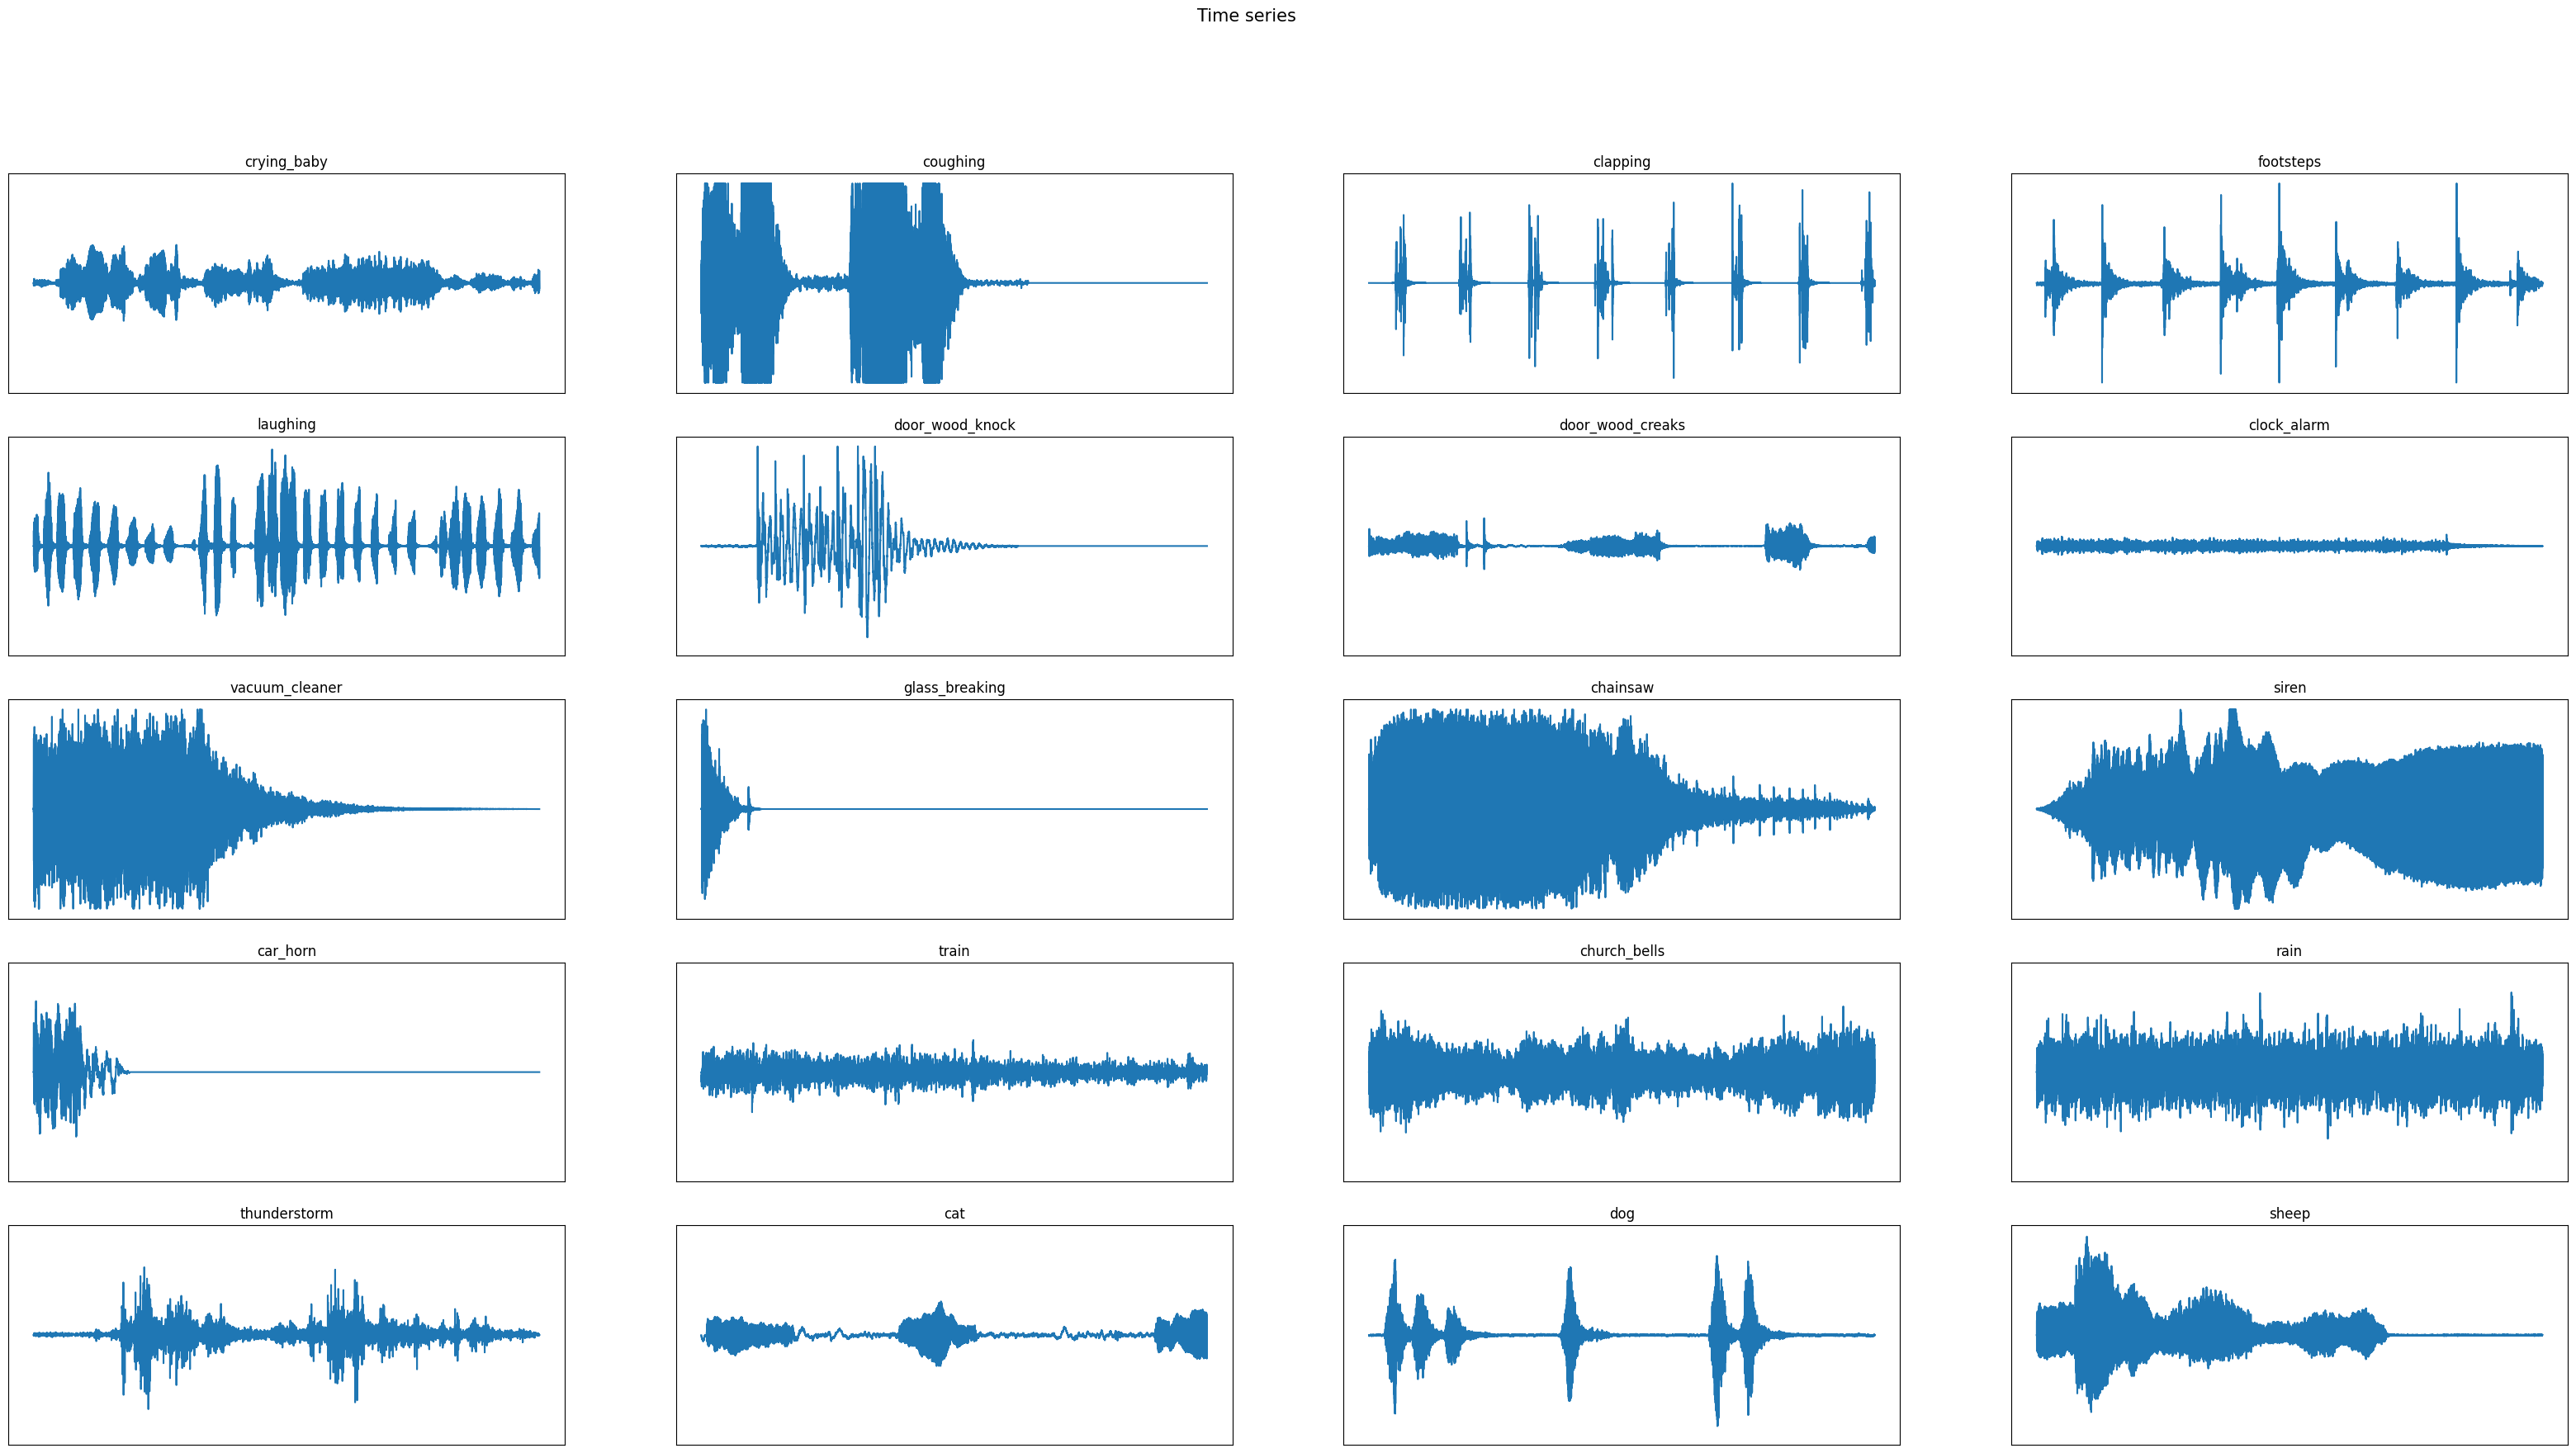

In [ ]:
plot_signal(signals)

### Visualization Mel Spectograms

In [ ]:
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=5 , ncols=4 , sharex=False, sharey=True , figsize=(20,10))
    fig.suptitle('mel')
    i=0
    for x in range(5):
        for y in range(4):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

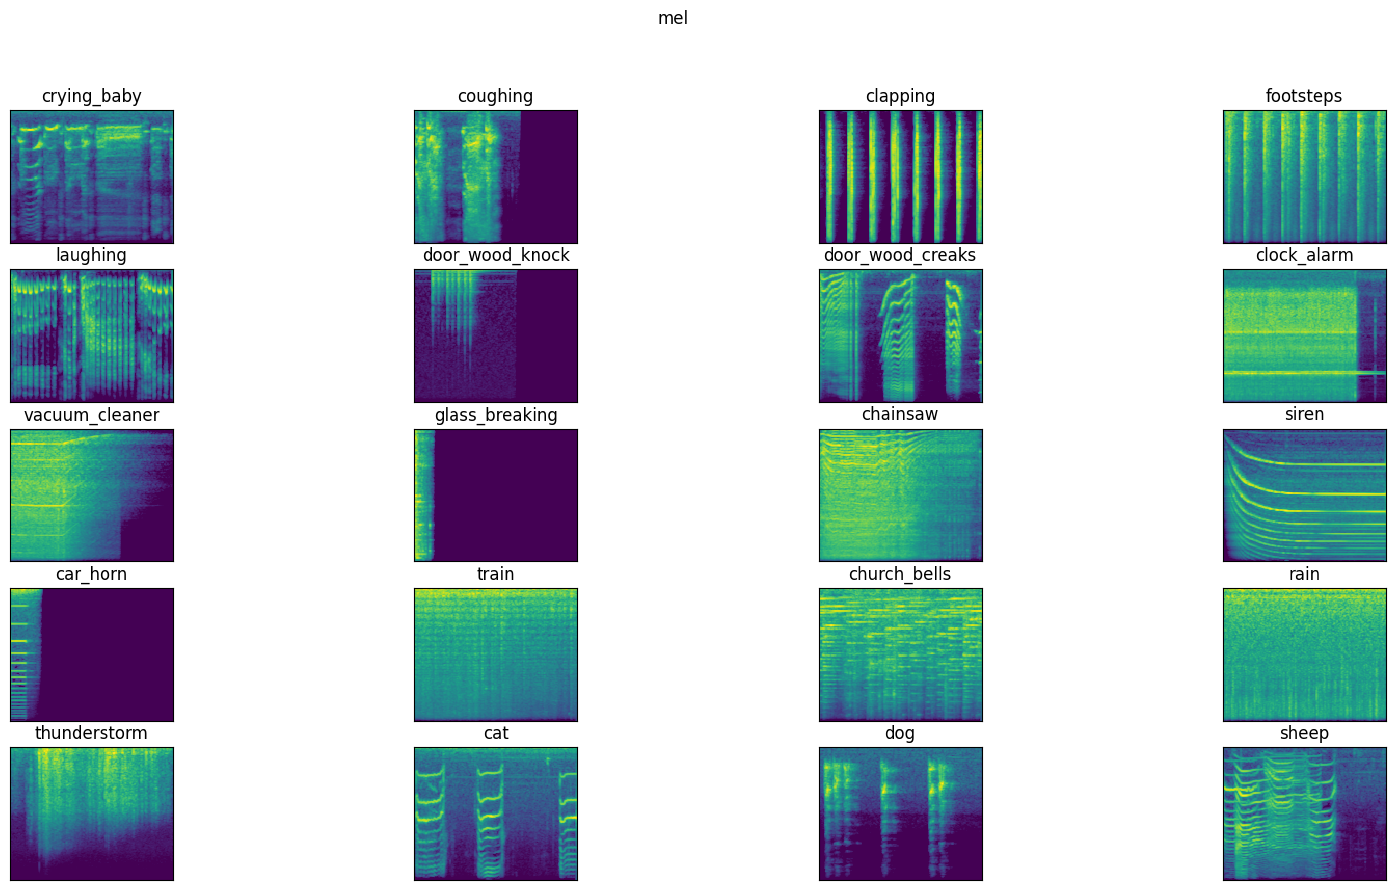

In [ ]:
dis_feature(mel_spectrograms)

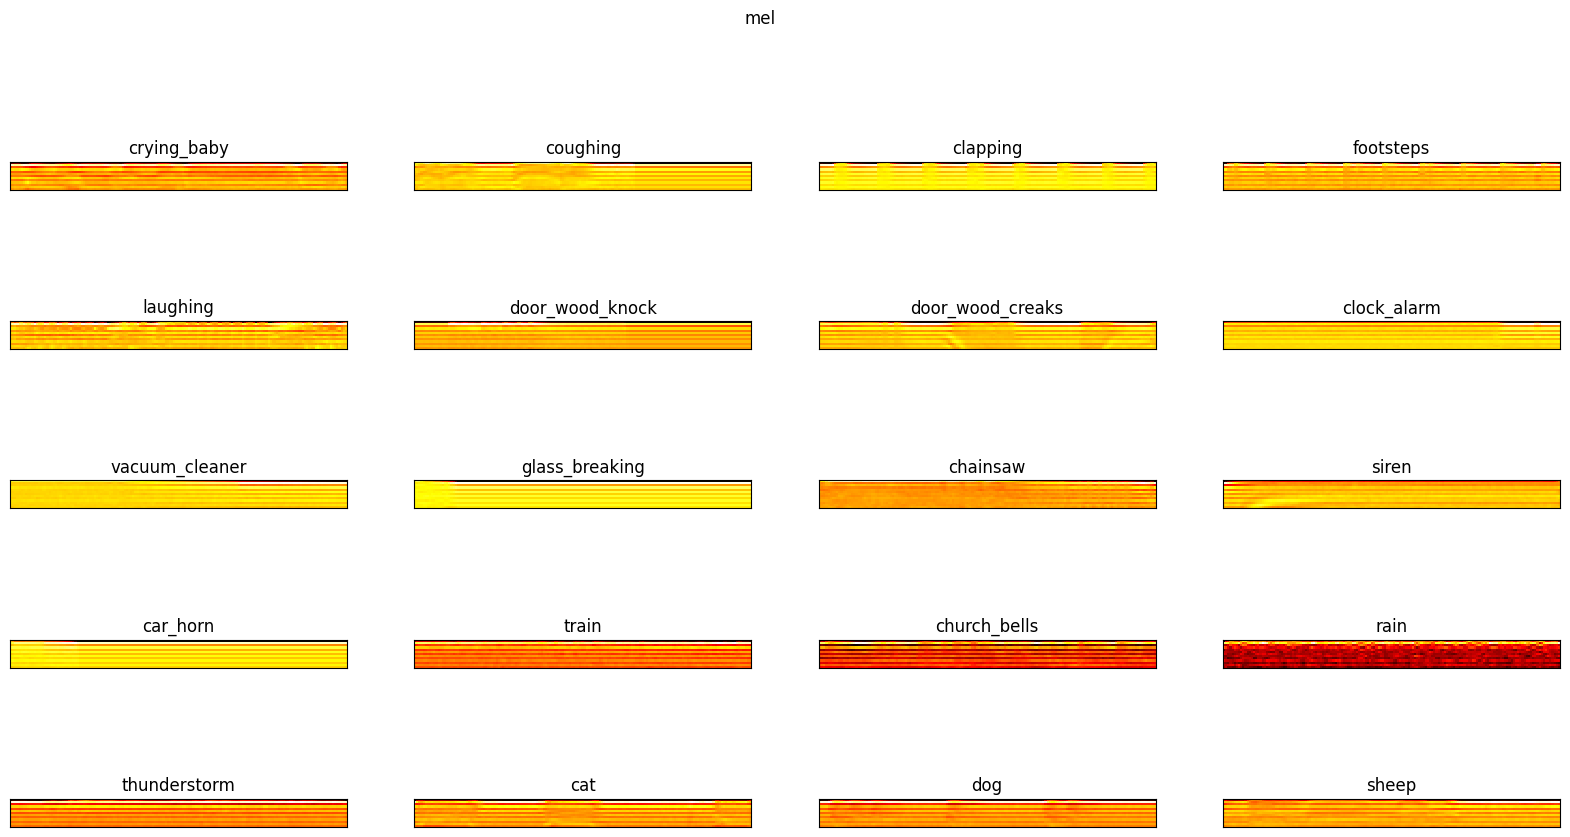

In [ ]:
dis_feature(mfccs, cmap='hot')

## Getting Data for Training


### generate 5 random 3 second clip from each audio file

In [ ]:
# Initialize lists to store features and target values
X, y = [], []

# Iterate over the DataFrame and process each audio file
for _, row in tqdm(filtered_pd.iterrows(), total=filtered_pd.shape[0]):
    file_path = os.path.join(audio_16k_path, row['filename'])
    try:
        # Load the audio file
        sig, sr = librosa.load(file_path)

        # Extract features and append to the list
        for i in range(5):  # Generating 5 samples per audio file
            n = np.random.randint(0, len(sig) - (sr * 3))
            sig_ = sig[n: int(n + (sr * 3))]
            mfcc_ = librosa.feature.mfcc(y=sig_, sr=sr, n_mfcc=13, dct_type=3)
            X.append(mfcc_)
            y.append(row['target_mapped'])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

100%|██████████| 800/800 [00:58<00:00, 13.77it/s]


### Preprocessing Data and One-Hot Encoding for TensorFlow Model"

In [ ]:
# Define the number of classes
num_classes = 20

# Create a mapping dictionary from the target values to a range [0, num_classes-1]
target_to_index = {category: i for i, category in enumerate(filtered_pd['category'].unique())}

# Map the 'category' column in the DataFrame to the new range
filtered_pd['target_mapped'] = filtered_pd['category'].map(target_to_index)

#one-hot encoding the target
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# our tensorflow model takes input as (no_of_sample , height , width , channel).
# here X has dimension (no_of_sample , height , width).
# So, the below code will reshape it to (no_of_sample , height , width , 1).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape
y.shape

(4000, 20)

In [ ]:
X.shape

(4000, 13, 130, 1)

### Split the Data

In [ ]:
x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2020)

## Build Model

In [ ]:
INPUTSHAPE = (13, 130, 1)

### Build Model Using CNN

In [ ]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='valid', input_shape=INPUTSHAPE),
    layers.Conv2D(16, (3, 3), activation='relu', padding='valid'),

    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),

    layers.GlobalAveragePooling2D(),

    layers.Dense(32, activation='relu'),
    layers.Dense(20, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 11, 128, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 9, 126, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 7, 124, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 5, 122, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 3, 120, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 1, 118, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,044 (215.02 KB)

 Trainable params: 55,044 (215.02 KB)

 Non-trainable params: 0 (0.00 B)

### Build Check Point to save model with the highest Validation Accuracy

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
filepath = 'my_best_model.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

### Ready for Training data with 100 epochs

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[callbacks])

Epoch 1/100
 94/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.0987 - loss: 2.9804
Epoch 1: val_acc improved from -inf to 0.19750, saving model to my_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.1020 - loss: 2.9664 - val_acc: 0.1975 - val_loss: 2.5369
Epoch 2/100
 92/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2801 - loss: 2.2883
Epoch 2: val_acc improved from 0.19750 to 0.39125, saving model to my_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.2833 - loss: 2.2772 - val_acc: 0.3913 - val_loss: 1.9573
Epoch 3/100
 96/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.4571 - loss: 1.7842
Epoch 3: val_acc improved from 0.39125 to 0.47875, saving model to my_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.4581 - loss: 1.7796 - val_acc: 0.4787 - val_loss: 1.6856
Epoch 4/100
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.5461 - loss: 1.4619
Epoch 4: val_acc improved from 0.47875 to 0.55625, saving model to my_best_model.keras
100/1

### Visualization the Result of Accuracy and Validation Accuracy

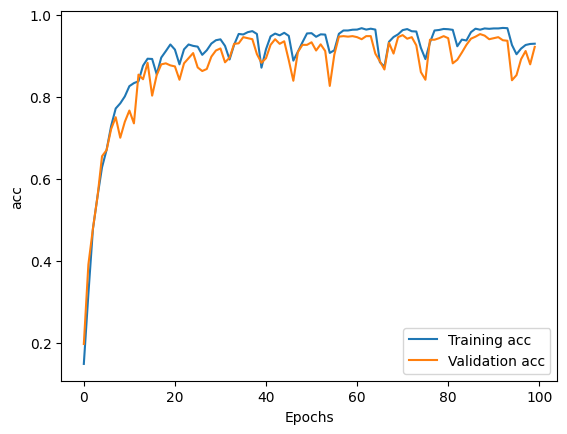

In [ ]:
#plot the training history
plt.plot(history.history['acc'], label='Training acc')
plt.plot(history.history['val_acc'], label='Validation acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.savefig('model_training_history')
plt.show()

### Save the Model

In [ ]:
#Load and evaluate the best model version
from keras.models import Sequential, load_model
model = load_model(filepath)

In [ ]:
model.save("my_best_model.h5")